In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [ ]:
# noms des variables de notre dataset y compris la variable identifiant IRIS
colonnes =["IDENT","TypeHabi", "GeoFaz_Scl", "GeoFaz_cl","Anciennete","Doublon_ligne",
            "Revenus_iris","Sexe","Prenom_Phase_scl_H", "Prenom_Phase_scl_F","Prenom_Phase_cl_H",
           "Prenom_Phase_cl_F","Age_H","Age_F","Pays_sud","Prenom_effectif","codif_RdB","Flag_PA",
           "Annee_1er_don","Cumul_dons","Don_max","Don_moyen","Vingtiles_ISF","IFI+"]

In [ ]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''
#/content/drive/MyDrive/Stage_methods_spad/data_excel_2.csv
data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/my_data_FDFIFI19.txt",delim_whitespace="\t" , header = None, names=colonnes, low_memory=False, )#, dtype='Int64')

In [ ]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(484522, 24)

In [ ]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,Anciennete,Doublon_ligne,Revenus_iris,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Pays_sud,Prenom_effectif,codif_RdB,Flag_PA,Annee_1er_don,Cumul_dons,Don_max,Don_moyen,Vingtiles_ISF,IFI+
0,101001347,3,75,7,8,3,3,3,64,46,6,4,9,4,2,3,3,2,7,7,6,4,10,2.0
1,201001512,1,74,7,5,3,3,4,65,81,6,8,11,12,2,4,3,2,8,5,2,2,10,2.0
2,301002801,2,32,3,7,2,4,4,66,66,6,6,11,9,2,3,3,2,8,7,5,3,7,2.0
3,401003186,1,12,1,4,3,7,3,51,81,5,8,9,12,2,5,1,2,2,7,8,6,18,2.0
4,501003624,2,12,1,6,3,3,3,51,81,5,8,9,12,2,5,1,2,8,7,8,6,2,2.0


In [ ]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train,shuffle=True ,cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()


def quarantiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 40)  )
    #print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    

    # pour la colonne IFI+ :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    data_all_complet_class = data_temp_t.fillna('2')
    #print(data_all_complet_class)

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","IFI+"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["IFI+"])
    #print(tab_cross_temp)
    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)
    
    # création du tableau final en éliminant la colonne 2
    tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)




In [ ]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,484522,484522
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,Anciennete,11,11
5,Doublon_ligne,3,3
6,Revenus_iris,8,8
7,Sexe,5,5
8,Prenom_Phase_scl_H,31,31
9,Prenom_Phase_scl_F,45,45


In [ ]:
data["IFI+"].value_counts(dropna=False)

2.0    462833
NaN     19069
1.0      2620
Name: IFI+, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484522 entries, 0 to 484521
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IDENT               484522 non-null  int64  
 1   TypeHabi            484522 non-null  int64  
 2   GeoFaz_Scl          484522 non-null  int64  
 3   GeoFaz_cl           484522 non-null  int64  
 4   Anciennete          484522 non-null  int64  
 5   Doublon_ligne       484522 non-null  int64  
 6   Revenus_iris        484522 non-null  int64  
 7   Sexe                484522 non-null  int64  
 8   Prenom_Phase_scl_H  484522 non-null  int64  
 9   Prenom_Phase_scl_F  484522 non-null  int64  
 10  Prenom_Phase_cl_H   484522 non-null  int64  
 11  Prenom_Phase_cl_F   484522 non-null  int64  
 12  Age_H               484522 non-null  int64  
 13  Age_F               484522 non-null  int64  
 14  Pays_sud            484522 non-null  int64  
 15  Prenom_effectif     484522 non-nul

In [ ]:

!pip install fanalysis

In [ ]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Annee_1er_don", "Cumul_dons", "Don_max", "Don_moyen"],axis=1)

#data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max", "Don_moyen", "GeoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F"],axis=1)

In [ ]:
num_var_max = data.shape[1] - 1
num_var_max

19

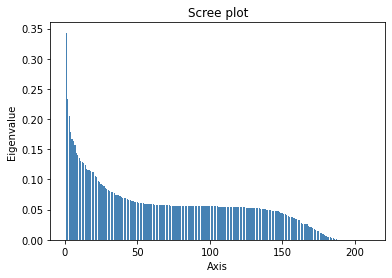

None


In [ ]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
acm.fit(data.iloc[:,1:num_var_max].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [ ]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [ ]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=10)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [ ]:
# dimension
coord.shape

(484522, 10)

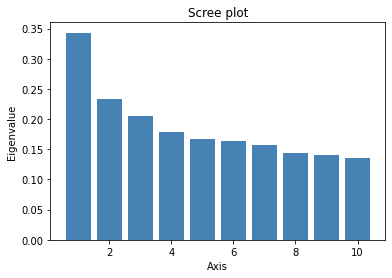

None


In [ ]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [ ]:
#coordonnées des colonnes
print(acm.col_topandas())

                  col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_1              0.334519        0.084540       -0.536292   
TypeHabi_2             -0.162766       -0.067546        0.227635   
TypeHabi_3              0.108481       -0.077526       -0.169052   
TypeHabi_4              0.583114        9.367491        5.444893   
GeoFaz_Scl_11          -0.183612        0.047279       -0.466513   
...                          ...             ...             ...   
Vingtiles_ISF_17        0.052709        0.039681       -0.520563   
Vingtiles_ISF_18        0.061751        0.091510       -0.689042   
Vingtiles_ISF_19        0.200347        0.243589       -1.074712   
Vingtiles_ISF_20        0.126740        0.275624       -1.158275   
Vingtiles_ISF_21        0.413903        8.802257        4.536745   

                  col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_1              0.147706       -0.628750        0.337084   
TypeHabi_2             -0.067833        0.31809

In [ ]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


19
[[ 3.00603826e-02  9.20982285e-03 -6.22231624e-02 ... -1.20782428e-02
   7.33688791e-02 -8.94274513e-03]
 [-1.46264226e-02 -7.35852379e-03  2.64112852e-02 ...  4.90500512e-03
  -3.34045554e-02  4.47637032e-03]
 [ 9.74827767e-03 -8.44571119e-03 -1.96142237e-02 ...  7.07479694e-04
   1.37104871e-02 -3.24049601e-03]
 ...
 [ 1.80034930e-02  2.65366640e-02 -1.24693244e-01 ... -1.80663354e-02
   1.01057007e-01 -1.26855938e-01]
 [ 1.13890311e-02  3.00265342e-02 -1.34388663e-01 ... -1.70941395e-02
   1.05709826e-01 -1.45887484e-01]
 [ 3.71938743e-02  9.58920070e-01  5.26374962e-01 ...  4.29584833e-02
  -7.12701317e-02 -9.33017063e-02]]
                         0         1         2         3         4         5  \
TypeHabi_1        0.030060  0.009210 -0.062223  0.018372 -0.080800  0.043850   
TypeHabi_2       -0.014626 -0.007359  0.026411 -0.008437  0.040877 -0.021672   
TypeHabi_3        0.009748 -0.008446 -0.019614  0.001258 -0.034480  0.017747   
TypeHabi_4        0.052399  1.020497  0.6

In [ ]:
# affichafe des 10 premières lignes
print(coord[:10,:])


[[ 0.07463833  0.15004173 -0.31740804 -0.47716482 -0.1678455  -0.13539515
   0.21231852 -0.9257133  -0.17813168 -0.02128022]
 [-0.30882139 -0.09829355  0.03220418 -0.51249373 -0.52942688  0.08595964
  -0.56881021 -0.12256462  0.14938711  0.19530714]
 [ 0.04876876 -0.35868338  0.57648941 -0.8597955  -0.33184627 -0.17750021
   0.20450243  0.39979045 -0.3031441   0.17318431]
 [-0.69838103 -0.01034565 -0.26666644  0.43161442 -0.52768549  0.38664216
   0.27978843 -0.28323729 -0.20552848 -0.3585937 ]
 [-0.74861542 -0.04912858  0.0965461   0.27486212 -0.05398284  0.34633499
   0.37357783 -0.32476018 -0.17337638  0.02964272]
 [-0.56496376  0.04411149 -0.21974992  0.3202937   0.0590757  -0.28783971
  -0.33134385  0.38343912  0.24562902  0.08183922]
 [ 0.55625301 -0.25284572  0.48229236  0.0681926   0.10153075  0.16472977
   0.47338082  0.31276821  0.21784688  0.35244663]
 [-0.65098388 -0.00269662 -0.14491629  0.42984402 -0.25419315  0.15369442
   0.26585616 -0.10347601 -0.41959029 -0.20130481]


In [ ]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484522 entries, 0 to 484521
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IDENT               484522 non-null  int64  
 1   TypeHabi            484522 non-null  int64  
 2   GeoFaz_Scl          484522 non-null  int64  
 3   GeoFaz_cl           484522 non-null  int64  
 4   Anciennete          484522 non-null  int64  
 5   Doublon_ligne       484522 non-null  int64  
 6   Revenus_iris        484522 non-null  int64  
 7   Sexe                484522 non-null  int64  
 8   Prenom_Phase_scl_H  484522 non-null  int64  
 9   Prenom_Phase_scl_F  484522 non-null  int64  
 10  Prenom_Phase_cl_H   484522 non-null  int64  
 11  Prenom_Phase_cl_F   484522 non-null  int64  
 12  Age_H               484522 non-null  int64  
 13  Age_F               484522 non-null  int64  
 14  Pays_sud            484522 non-null  int64  
 15  Prenom_effectif     484522 non-nul

In [ ]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable IFI+
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(10):
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["IFI+"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable IFI+

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(10):
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["IFI+"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["IFI+"] = dfff["IFI+"].replace(1.0, '1')
    dfff["IFI+"] = dfff["IFI+"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 465453 entries, 0 to 466516
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   IDENT   465453 non-null  int64  
 1   0       465453 non-null  float64
 2   1       465453 non-null  float64
 3   2       465453 non-null  float64
 4   3       465453 non-null  float64
 5   4       465453 non-null  float64
 6   5       465453 non-null  float64
 7   6       465453 non-null  float64
 8   7       465453 non-null  float64
 9   8       465453 non-null  float64
 10  9       465453 non-null  float64
 11  IFI+    465453 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 46.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484522 entries, 0 to 484521
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   IDENT   484522 non-null  int64  
 1   0       484522 non-null  float64
 2   1       484522 non-null  float64
 3  

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


In [ ]:
#data_coord_nan.shape
#train_X_s.shape

In [ ]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting, on fait une augmentation de données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(train_X_s, train_Y_s ) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.0002,0.0003]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

test set : 
[[  328   170]
 [28168 64425]]
              precision    recall  f1-score   support

           1       0.01      0.66      0.02       498
           2       1.00      0.70      0.82     92593

    accuracy                           0.70     93091
   macro avg       0.50      0.68      0.42     93091
weighted avg       0.99      0.70      0.82     93091

train set : 
[[243879 126361]
 [112183 258057]]
              precision    recall  f1-score   support

           1       0.68      0.66      0.67    370240
           2       0.67      0.70      0.68    370240

    accuracy                           0.68    740480
   macro avg       0.68      0.68      0.68    740480
weighted avg       0.68      0.68      0.68    740480



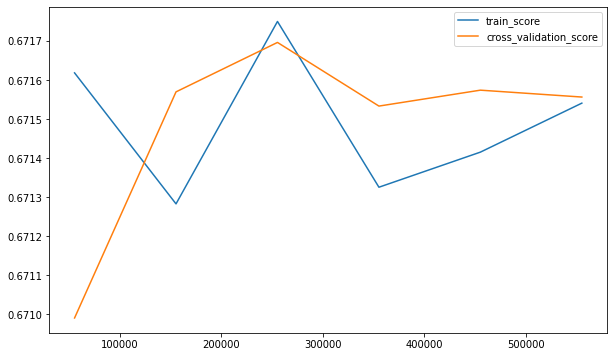

In [ ]:
model_17 = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(model_17, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1")

In [ ]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["IFI+"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_1,-0.259510
TypeHabi_2,0.123737
TypeHabi_3,-0.083650
TypeHabi_4,0.027500
GeoFaz_Scl_11,-0.140918
...,...
Vingtiles_ISF_17,-0.212230
Vingtiles_ISF_18,-0.370366
Vingtiles_ISF_19,-0.581200
Vingtiles_ISF_20,-0.631143


In [ ]:
quarantiles(model = adl, data_orig=data_coord_avec_nan, affichage=True, save=True, path = "/content/drive/MyDrive/spad_score_method_1/sans_val_dons_LinearAnalysisDiscriminant.xlsx")

0.065625    90
0.003270    81
0.026989    78
0.002772    69
0.006544    66
            ..
0.000904     1
0.001939     1
0.002430     1
0.001195     1
0.001252     1
Name: PROBA, Length: 414882, dtype: int64
IFI+                      1      2  TOTAL
TRANCHES                                 
(-0.0009232, 0.000681]   16  12098  12114
(0.000681, 0.000797]     18  12095  12113
(0.000797, 0.0009]       22  12091  12113
(0.0009, 0.00101]        15  12098  12113
(0.00101, 0.00112]       18  12095  12113
(0.00112, 0.00123]       14  12099  12113
(0.00123, 0.00134]       26  12088  12114
(0.00134, 0.00146]       17  12095  12112
(0.00146, 0.00157]       31  12083  12114
(0.00157, 0.00168]       31  12081  12112
(0.00168, 0.0018]        25  12088  12113
(0.0018, 0.00191]        32  12081  12113
(0.00191, 0.00202]       21  12092  12113
(0.00202, 0.00214]       27  12086  12113
(0.00214, 0.00227]       33  12080  12113
(0.00227, 0.0024]        33  12080  12113
(0.0024, 0.00254]        40  12075  1

test set : 
[[  376   122]
 [46515 46078]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02       498
           2       1.00      0.50      0.66     92593

    accuracy                           0.50     93091
   macro avg       0.50      0.63      0.34     93091
weighted avg       0.99      0.50      0.66     93091

train set : 
[[287521  82719]
 [186148 184092]]
              precision    recall  f1-score   support

           1       0.61      0.78      0.68    370240
           2       0.69      0.50      0.58    370240

    accuracy                           0.64    740480
   macro avg       0.65      0.64      0.63    740480
weighted avg       0.65      0.64      0.63    740480



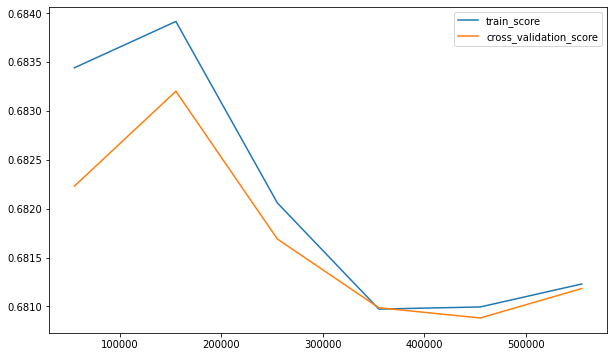

In [ ]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1")


In [ ]:
quarantiles(model=model_17, data_orig=data_coord_avec_nan, affichage=True, save=True, path = "/content/drive/MyDrive/spad_score_method_1/sans_dons_QuadraticAnalysisDiscriminant.xlsx")

0.894585    90
0.429940    81
0.779286    78
0.392239    69
0.649434    66
            ..
0.273440     1
0.137856     1
0.699530     1
0.602330     1
0.332163     1
Name: PROBA, Length: 414882, dtype: int64
IFI+               1      2  TOTAL
TRANCHES                          
(0.0131, 0.121]   11  12103  12114
(0.121, 0.141]    15  12098  12113
(0.141, 0.157]    24  12089  12113
(0.157, 0.171]    20  12093  12113
(0.171, 0.186]    19  12094  12113
(0.186, 0.202]    14  12099  12113
(0.202, 0.217]    13  12100  12113
(0.217, 0.231]    22  12091  12113
(0.231, 0.246]    34  12079  12113
(0.246, 0.259]    32  12082  12114
(0.259, 0.272]    24  12088  12112
(0.272, 0.284]    37  12076  12113
(0.284, 0.295]    21  12092  12113
(0.295, 0.306]    25  12088  12113
(0.306, 0.317]    25  12088  12113
(0.317, 0.328]    32  12081  12113
(0.328, 0.339]    35  12078  12113
(0.339, 0.351]    34  12079  12113
(0.351, 0.363]    45  12068  12113
(0.363, 0.376]    31  12082  12113
(0.376, 0.389]    46  1

In [ ]:
data_coord_avec_nan.shape

(484522, 12)

In [ ]:
#################################################################################
#################################################################################

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


'\nfrom sklearn.preprocessing import KBinsDiscretizer\n# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)\n c\'est qui est bien avec KBinsDiscretizer est qu\'il s\'adapte aux éventuelles partitions au\nsein d\'une variable. En d\'autres termes, si la méthode n\'arrive pas à partitionner les individus\nen k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, \njusqu\'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement \nune modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer \nl\'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.\n\n\nmethod_discre = KBinsDiscretizer(n_bins=4, encode=\'ordinal\', strategy=\'quantile\') \nmethod_discre.fit(data.iloc[:,1:23])\nresultat_discre = method_discre.transform(data.iloc[:,1:23])\nresultat_discre\n\n# construction du data frame après discrétisation\ndata2_index 

int